# Efficiency of Peak Detection Methods

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%capture
import sys
sys.path.insert(0, '/home/raf_pc/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

# Working environment
temp_repo_dir = "/home/raf_pc/Kemal/Temp"
data_repo_dir = "/home/raf_pc/Kemal/Data"

# SAM files for ribosome stalling data and coco assembly data
spt = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_TT1.sam", "60mer_TT2.sam"]]
sps = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_Rep1.sam", "60mer_Rep2.sam", "60mer_NoPK.sam"]]

# Exculude the gene below because it has over-expression problem.
exclude_genes = ["ENSG00000160789"]

# Create the infrastructure object
I = Infrastructre(temp_repo_dir,
                  exclude_genes=exclude_genes,
                  riboseq_assign_at=-15,
                  riboseq_assign_to="best_transcript",
                  ensembl_release=102,
                  verbose=True, 
                  sixtymers=[spt, sps])

## Aminoacid Charge

In [3]:
from functools import partial
from copy import deepcopy

window_len = 181
window_flank = int(np.floor(window_len / 2))
percentiles = (60, 70, 80, 85, 90, 92.5, 95, 97.5, 99)
probabilities = (0.120, 0.080, 0.050, 0.025, 0.0175, 0.010, 0.004, 0.0025, 0.001)
assert window_len % 2 == 1 and window_len >= 3
assert len(percentiles) == len(probabilities)

# Methods
inecik1 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_1, window="hanning", window_len=23, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
inecik2 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_2, window="hanning", window_len=23, wlen=300, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
inecik3 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_3, window="hanning", window_len=23, wlen=300, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
inecik4 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_4, window="hanning", window_len=23, wlen=300, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
arpat = partial(I.riboseq_sixtymers.stalling_peaks_arpat, mmc_threshold=1, normalized_peak_count_thr=5, get_top=5)

save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_protein_sequences_params_percentile.joblib")
try:  # Because it takes very long, as written very inefficiently.
    W = joblib.load(save_metadata_path)
except FileNotFoundError:

    ci = [[] for _ in range(len(percentiles))]
    windows = [deepcopy(ci), deepcopy(ci), deepcopy(ci), deepcopy(ci), [], []]  # inecik1, inecik2, inecik3, inecik4, arpat, monte_carlo

    for ind, gene_id in enumerate(I.gene_list):
        progress_bar(ind, len(I.gene_list) - 1, verbose=True)
        best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
        protein_sequence = I.protein_genome.db[best_transcript][1]
        length_protein = len(protein_sequence)
        assert "." not in protein_sequence
        protein_sequence = "." * window_flank + protein_sequence + "." * window_flank
        # My methods
        for param1 in range(len(percentiles)):
            peaks1 = (np.floor(inecik1(gene_id, percentile=percentiles[param1]) / 3) + window_flank).astype(int)
            peaks2 = (np.floor(inecik2(gene_id, percentile=percentiles[param1]) / 3) + window_flank).astype(int)
            peaks3 = (np.floor(inecik3(gene_id, probability=probabilities[param1]) / 3) + window_flank).astype(int)
            peaks4 = (np.floor(inecik4(gene_id, percentile=percentiles[param1]) / 3) + window_flank).astype(int)
            for inecik_method, peaks in zip(range(4), [peaks1, peaks2, peaks3, peaks4]):
                for peak in peaks:
                    windows[inecik_method][param1].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
        # Arpat
        peaks5 = (np.floor(arpat(gene_id) / 3) + window_flank).astype(int)
        for peak in peaks5:
            windows[4].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
        # Monte Carlo
        peaks_mc = (np.sort(np.random.choice(length_protein, 10)) + window_flank).astype(int)
        for peak in peaks_mc:
            windows[5].append(protein_sequence[peak - window_flank: peak + window_flank + 1])        

    ci = [None for _ in range(len(percentiles))]
    W = [deepcopy(ci), deepcopy(ci), deepcopy(ci), deepcopy(ci), None, None]  # inecik1, inecik2, inecik3, inecik4, arpat, monte_carlo

    for inecik_method in range(4):
        for param1 in range(len(percentiles)):
            W_temp = np.chararray((len(windows[inecik_method][param1]), window_len), itemsize=1)
            W_temp[:] = "."
            for ind, peak_window in enumerate(windows[inecik_method][param1]):
                W_temp[ind] = list(peak_window)
            W[inecik_method][param1] = W_temp
    for other_method in range(4, 6):
        W_temp = np.chararray((len(windows[other_method]), window_len), itemsize=1)
        W_temp[:] = "."
        for ind, peak_window in enumerate(windows[other_method]):
            W_temp[ind] = list(peak_window)
        W[other_method] = W_temp

    del windows
    joblib.dump(W, save_metadata_path)

Progress: |█████████-----------| 46.1% 

/home/raf_pc/Kemal/RiboSeqAnalysis/infrastructure/main.py:919: RuntimeWarning: invalid value encountered in greater
  normalized_peak_count = np.sum(land > 0)  # to test whether normalized peak count > 5


Progress: |████████████████████| 100.0% 


In [35]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
charges = list()
for k in range(4):
    charges_method = list()
    for i in range(len(percentiles)):
        charges_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_charge = pa.charge_at_pH(7) / len(aminoacids_vertical)
            charges_temp.append(average_charge)
        charges_method.append(charges_temp)
    charges.append(charges_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    charges_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_charge = pa.charge_at_pH(7) / len(aminoacids_vertical)
        charges_temp.append(average_charge)
    charges.append(charges_temp)

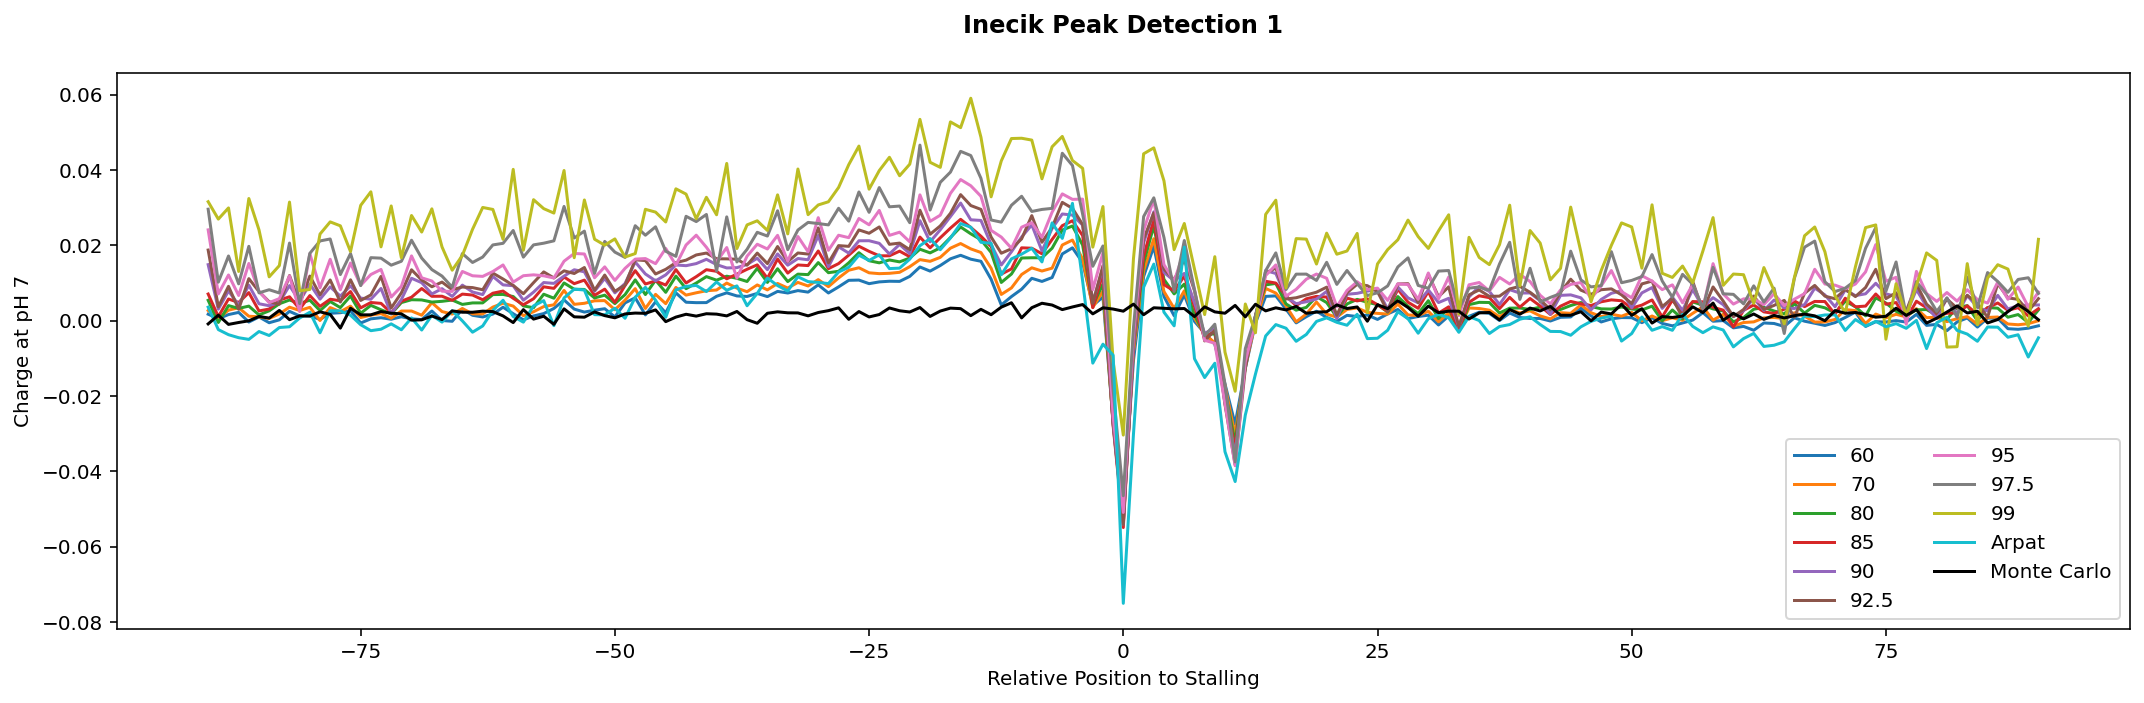

In [212]:
m = 0
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, charges[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, charges[4], label="Arpat")
plt.plot(x, charges[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Charge at pH 7")
plt.tight_layout()
plt.show()

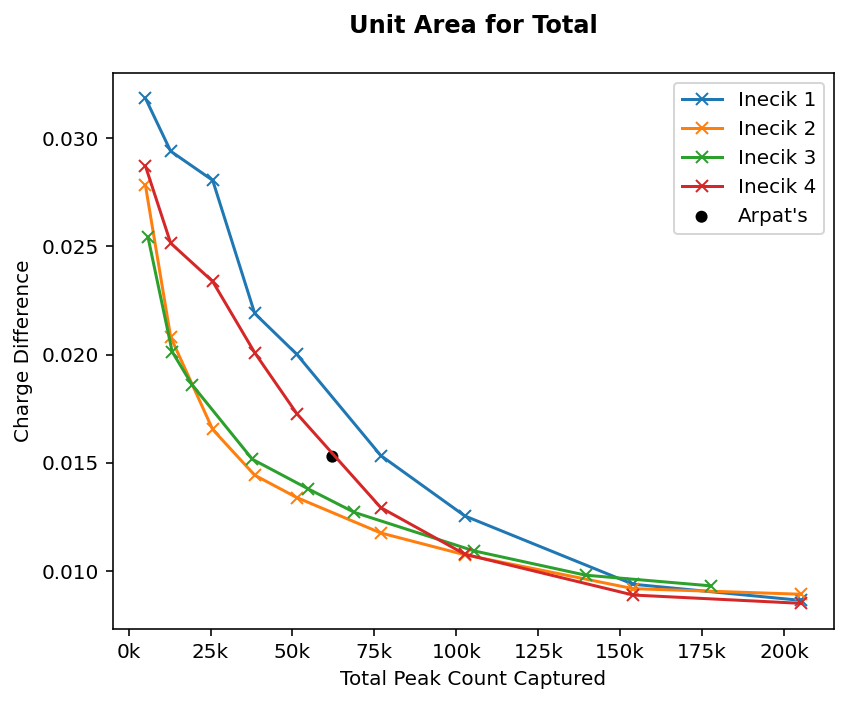

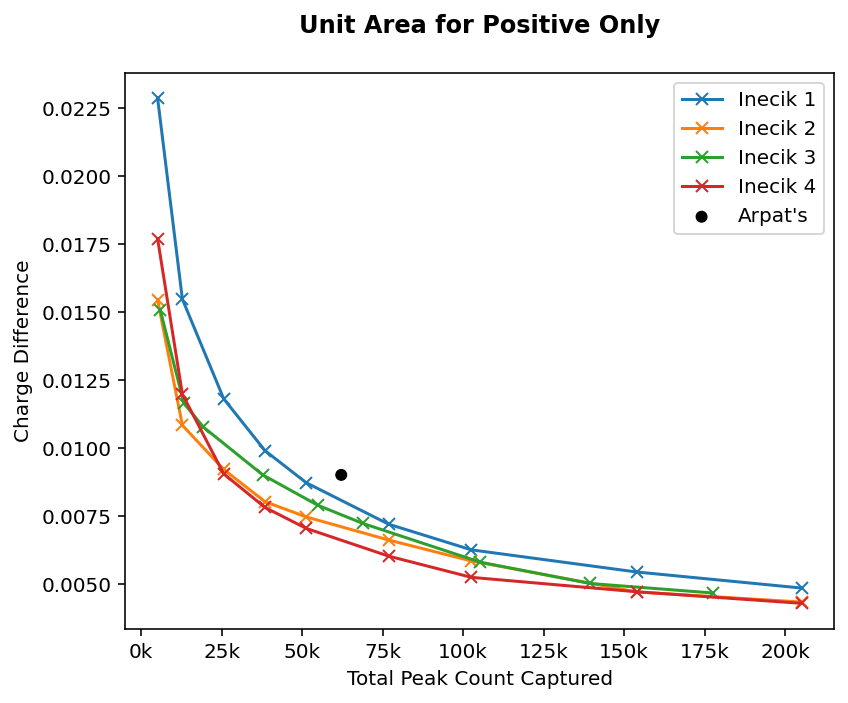

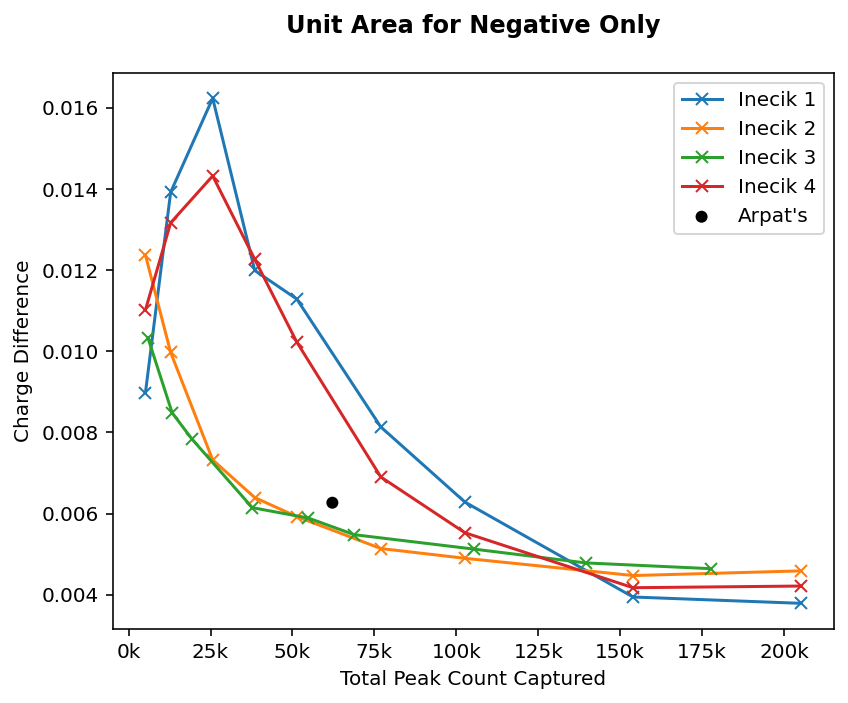

In [196]:
def objective_function(x1, x2, method):
    diff = np.array(x1) - np.array(x2) # calculate difference
    posPart = np.maximum(diff, 0) # only keep positive part, set other values to zero
    negPart = -np.minimum(diff, 0) # only keep negative part, set other values to zero    
    posAreaRatio = np.trapz(posPart) / np.sum(diff > 0)
    negAreaRatio = np.trapz(negPart) / np.sum(diff < 0)
    if method == "Total":
        return posAreaRatio + negAreaRatio
    elif method == "Positive Only":
        return posAreaRatio
    elif method == "Negative Only":
        return negAreaRatio

for method in ["Total", "Positive Only", "Negative Only"]:
    of = partial(objective_function, method=method)
    
    fig = plt.figure(figsize=(6, 5))
    for m in range(4):
        lengths = [len(W[m][i]) for i in range(len(percentiles))]
        score = [of(charges[m][k], np.array(charges[5])) for k in range(len(percentiles))]
        plt.plot(lengths, score, marker="x", label=f"Inecik {m+1}")
    arpat_score = of(charges[4], charges[5])
    arpat_length = len(W[4])
    plt.scatter(arpat_length, arpat_score, edgecolors="None", label="Arpat's", color="black")
    plt.title(f"Unit Area for {method}", y=1.05, fontweight="bold")
    plt.xlabel("Total Peak Count Captured")
    plt.ylabel("Charge Difference")
    plt.gca().set_xticklabels(['{:,.0f}'.format(x) + 'k' for x in plt.gca().get_xticks()/1000])
    plt.legend()
    plt.tight_layout()
    plt.show()
    

## The grand average of hydropathy (GRAVY) value 

In [225]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
gravy_scores = list()
for k in range(4):
    gravy_method = list()
    for i in range(len(percentiles)):
        gravy_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_gravy = pa.gravy()
            gravy_temp.append(average_gravy)
        gravy_method.append(gravy_temp)
    gravy_scores.append(gravy_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    gravy_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_gravy = pa.gravy()
        gravy_temp.append(average_gravy)
    gravy_scores.append(gravy_temp)

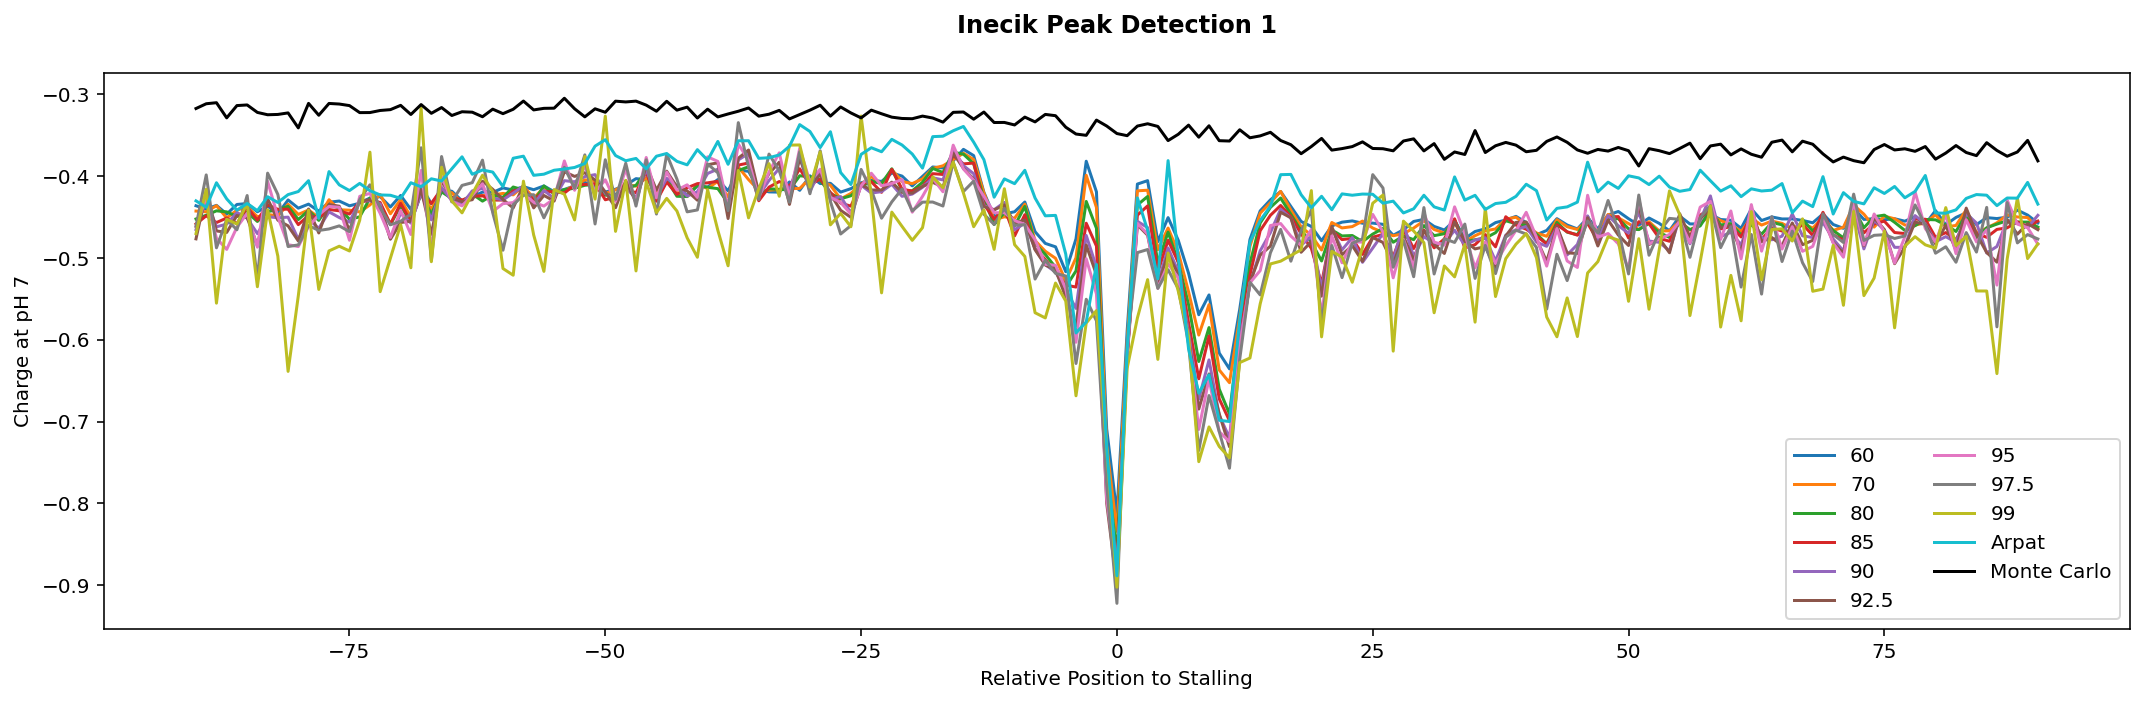

In [232]:
m = 0
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, gravy_scores[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, gravy_scores[4], label="Arpat")
plt.plot(x, gravy_scores[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Gravy Score")
plt.tight_layout()
plt.show()

## Molecular Weight

In [238]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
molwei = list()
for k in range(4):
    molwei_method = list()
    for i in range(len(percentiles)):
        molwei_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_mw = pa.molecular_weight() / len(aminoacids_vertical)
            molwei_temp.append(average_mw)
        molwei_method.append(molwei_temp)
    molwei.append(molwei_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    molwei_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_mw = pa.molecular_weight() / len(aminoacids_vertical)
        molwei_temp.append(average_mw)
    molwei.append(molwei_temp)

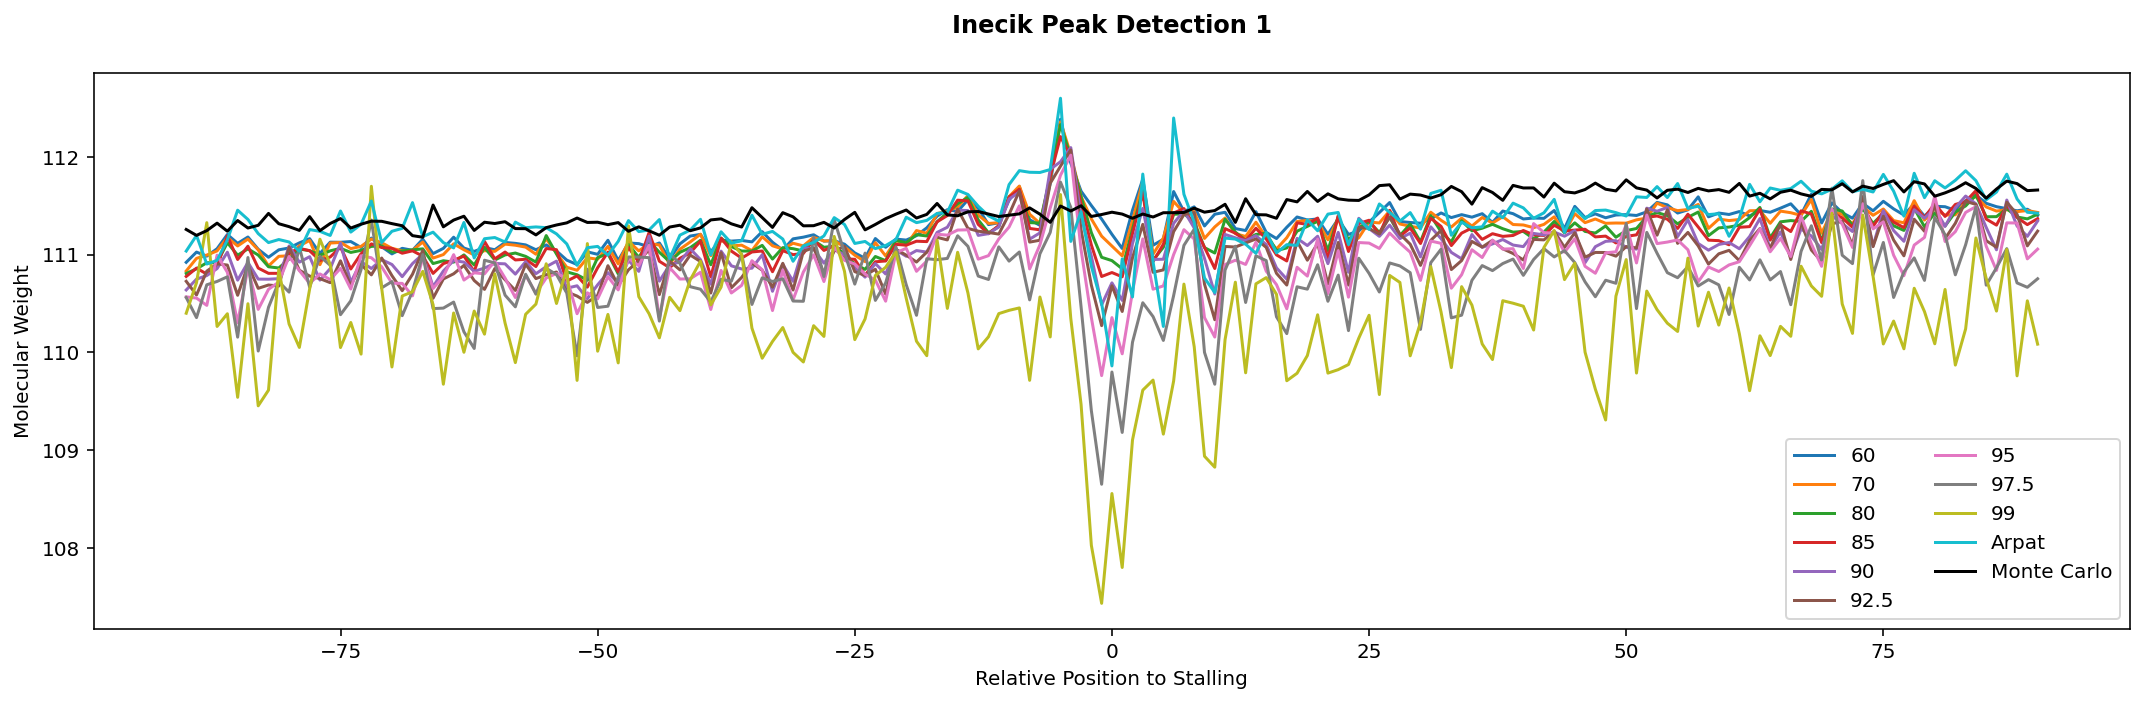

In [239]:
m = 0
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, molwei[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, molwei[4], label="Arpat")
plt.plot(x, molwei[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Molecular Weight")
plt.tight_layout()
plt.show()

## Proline residues

In [249]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
proline = list()
for k in range(4):
    proline_method = list()
    for i in range(len(percentiles)):
        proline_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_proline = pa.get_amino_acids_percent()["P"]
            proline_temp.append(average_proline)
        proline_method.append(proline_temp)
    proline.append(proline_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    proline_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_proline = pa.get_amino_acids_percent()["P"]
        proline_temp.append(average_proline)
    proline.append(proline_temp)

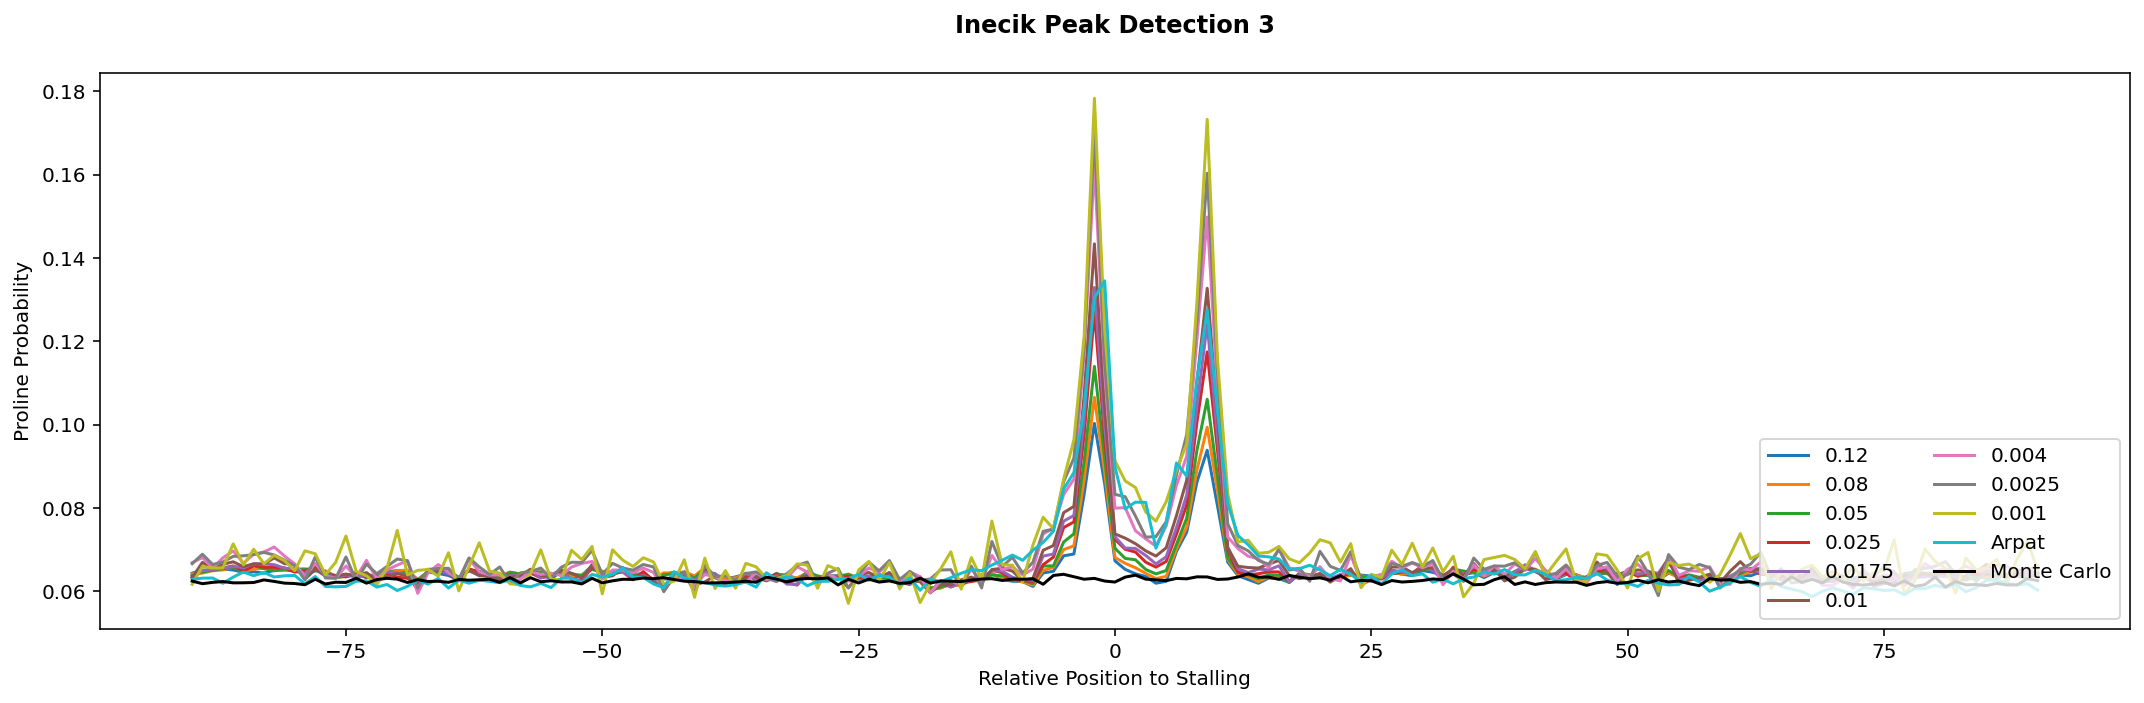

In [254]:
m = 2
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, proline[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, proline[4], label="Arpat")
plt.plot(x, proline[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Proline Probability")
plt.tight_layout()
plt.show()

In [247]:
# scan wlen

In [255]:
# logomaker

In [ ]:
# https://web.expasy.org/protparam/protparam-doc.html
# https://web.expasy.org/protscale/
# https://biopython.org/docs/1.75/api/Bio.SeqUtils.ProtParam.html

In [ ]:
# Screen'i bitirip mail at

In [325]:
# Threshold'u editle, alt ve üst limitleri seçebil, yani üst threshold da olsun defaultta >100 olsun tabi.
# Plotting'de etkili olur

In [ ]:
# Monte karlo şu olsun: aynı miktarda peak'i seç from a given gene. o monte karlo o percentile'e ait olsun.

In [ ]:
# Objective function şu olsun: charge - monte carlo.

In [ ]:
# Number of peaks vs objective function grafiği çiz. elbow point'i al.

In [21]:
k=np.array([1,2,3,4,5])
k[k>3]


array([4, 5])

array([50.        , 55.12527205, 60.77591238, 67.00577408, 73.87423051,
       81.44674109, 89.79547521, 99.        ])